## Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

## Uncertain Space

In [4]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [5]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':convert_from('kN',150),'n_pax':150.0,'area':180.0,'ar':9.0,'fuel_type':'kerosene','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [7]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 17:29:47: *** Start Sampling execution ***
    INFO - 17:29:47: Sampling
    INFO - 17:29:47:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:29:47:    MDO formulation: MDF
    INFO - 17:29:47: Running the algorithm OT_MONTE_CARLO:
    INFO - 17:29:49:    100%|██████████| 100/100 [00:02<00:00, 49.54 it/sec]
    INFO - 17:29:49: *** End Sampling execution (time: 0:00:02.038129) ***


In [8]:
surrogate_discipline = SurrogateDiscipline("PolynomialRegressor", training_dataset)

In [9]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([0.99999999]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [10]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.99999999]),
 'length': array([nan]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [11]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([1.55374092e-06]),
 'length': array([0.]),
 'mtom': array([0.00126442]),
 'span': array([0.]),
 'tofl': array([6.17282348e-05]),
 'vapp': array([4.24575929e-07]),
 'vz': array([2.11188527e-06])}

In [12]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([1.8739296e-06]),
 'length': array([0.]),
 'mtom': array([0.00170871]),
 'span': array([0.]),
 'tofl': array([8.7968712e-05]),
 'vapp': array([5.28247342e-07]),
 'vz': array([2.6778924e-06])}

In [13]:
from matplotlib import pyplot as plt
from gemseo import sample_disciplines
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [14]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00788825]),
 'cef': array([1.00629333]),
 'fm': array([1.19169286]),
 'length': array([37.]),
 'mtom': array([75072.62669421]),
 'sef': array([1.00791544]),
 'span': array([40.24922359]),
 'tofl': array([1128.2551138]),
 'vapp': array([56.76798795]),
 'vz': array([7.34141378])}

In [15]:
variance = statistics.compute_variance()
variance

{'aef': array([7.37077678e-05]),
 'cef': array([8.44338002e-05]),
 'fm': array([0.00035496]),
 'length': array([0.]),
 'mtom': array([108523.81364031]),
 'sef': array([7.1277677e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([81.97279175]),
 'vapp': array([0.01928714]),
 'vz': array([0.01228967])}

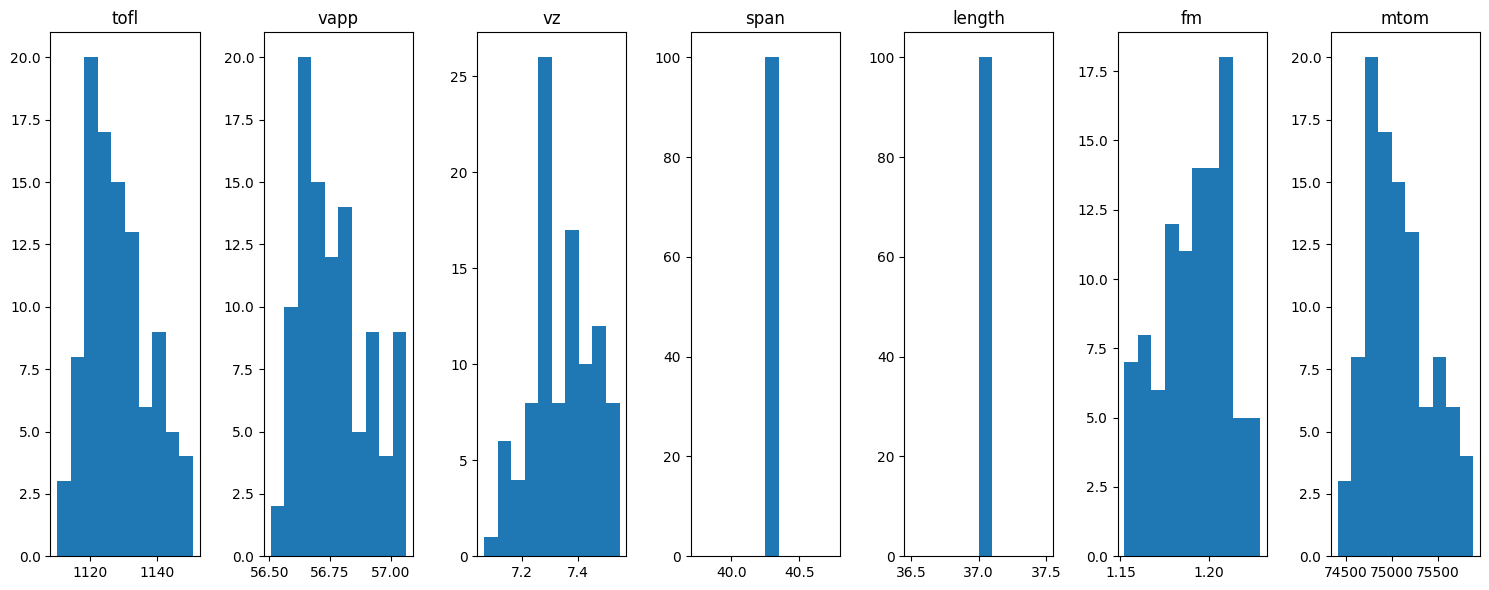

In [16]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [17]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [18]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 100)

 WARNING - 17:29:52: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:29:52: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 17:29:52: SobolAnalysisSamplingPhase
    INFO - 17:29:52:    Disciplines: PolyReg_Sampling
    INFO - 17:29:52:    MDO formulation: MDF
    INFO - 17:29:52: Running the algorithm OT_SOBOL_INDICES:
    INFO - 17:29:53:    100%|██████████| 96/96 [00:01<00:00, 64.48 it/sec]
    INFO - 17:29:53: *** End SobolAnalysisSamplingPhase execution (time: 0:00:01.514490) ***


GROUP        inputs                       outputs                       \
VARIABLE        aef       cef       sef        fm length          mtom   
COMPONENT         0         0         0         0      0             0   
0          1.011287  1.018858  1.018127  1.163468   37.0  75627.925974   
1          0.996470  0.998531  0.994315  1.218575   37.0  74400.103590   
2          1.012159  1.000496  1.024286  1.198833   37.0  75644.773678   
3          0.999643  0.997105  0.997688  1.218251   37.0  74528.953649   
4          0.999603  1.028623  0.996241  1.156128   37.0  74849.988424   
..              ...       ...       ...       ...    ...           ...   
91         0.995934  0.999781  0.997909  1.216582   37.0  74547.049738   
92         1.016577  1.002006  1.006415  1.191441   37.0  75016.706626   
93         1.005482  0.997079  0.994671  1.212402   37.0  74449.892298   
94         1.021060  1.007666  1.003858  1.175819   37.0  75015.207051   
95         1.011845  1.020575  1.001509  1.159603   37.0  75026.579229   

GROUP                                                   
VARIABLE        span         tofl       vapp        vz  
COMPONENT          0            0          0         0  
0          40.249224  1143.538772  56.935992  7.171700  
1          40.249224  1109.852202  56.543852  7.595278  
2          40.249224  1144.004908  57.036980  7.161742  
3          40.249224  1113.361445  56.599577  7.539991  
4          40.249224  1122.131108  56.575672  7.453350  
..               ...          ...        ...       ...  
91         40.249224  1113.854760  56.603213  7.558692  
92         40.249224  1126.700409  56.743450  7.300968  
93         40.249224  1111.207452  56.549749  7.524403  
94         40.249224  1126.659265  56.701331  7.273116  
95         40.249224  1126.971327  56.662605  7.328207  

[96 rows x 10 columns]

In [19]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'aef': array([0.16516801]), 'cef': array([0.29472247]), 'sef': array([0.22864872])}], 'vapp': [{'aef': array([0.10536703]), 'cef': array([0.10536699]), 'sef': array([0.28507739])}], 'vz': [{'aef': array([0.43213036]), 'cef': array([0.40728455]), 'sef': array([0.11509242])}], 'fm': [{'aef': array([-0.23279312]), 'cef': array([0.97321093]), 'sef': array([-0.24966353])}], 'mtom': [{'aef': array([0.16550527]), 'cef': array([0.2958868]), 'sef': array([0.22997507])}]}, second={'tofl': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.35258262]]), 'sef': array([[-0.30831946]])}, 'cef': {'aef': array([[-0.35258262]]), 'cef': array([[0.]]), 'sef': array([[-0.39142565]])}, 'sef': {'aef': array([[-0.30831946]]), 'cef': array([[-0.39142565]]), 'sef': array([[0.]])}}], 'vapp': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.20246806]]), 'sef': array([[-0.20246833]])}, 'cef': {'aef': array([[-0.20246806]]), 'cef': array([[0.]]), 'sef': array([[-0.2

In [20]:
import pprint

In [21]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([-0.23279312]),
         'cef': array([0.97321093]),
         'sef': array([-0.24966353])}],
 'mtom': [{'aef': array([0.16550527]),
           'cef': array([0.2958868]),
           'sef': array([0.22997507])}],
 'tofl': [{'aef': array([0.16516801]),
           'cef': array([0.29472247]),
           'sef': array([0.22864872])}],
 'vapp': [{'aef': array([0.10536703]),
           'cef': array([0.10536699]),
           'sef': array([0.28507739])}],
 'vz': [{'aef': array([0.43213036]),
         'cef': array([0.40728455]),
         'sef': array([0.11509242])}]}
{'fm': [{'aef': array([0.0766252]),
         'cef': array([1.17831817]),
         'sef': array([-8.09099971e-05])}],
 'mtom': [{'aef': array([-0.03044584]),
           'cef': array([0.06048295]),
           'sef': array([0.78487982])}],
 'tofl': [{'aef': array([-0.0313882]),
           'cef': array([0.06012727]),
           'sef': array([0.78603334])}],
 'vapp': [{'aef': array([-0.00056174]),
           'cef': ar

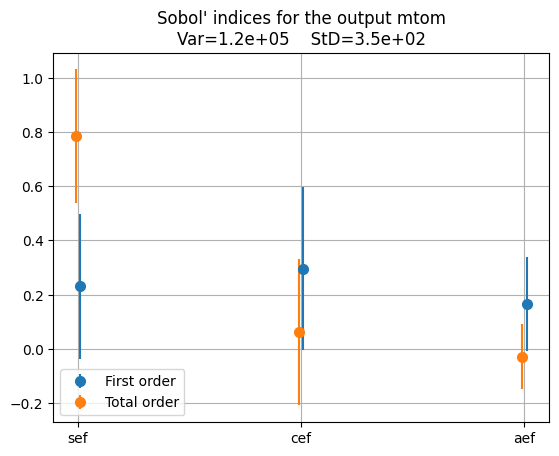

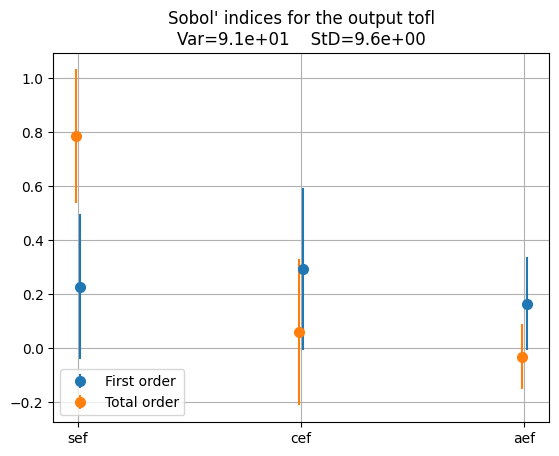

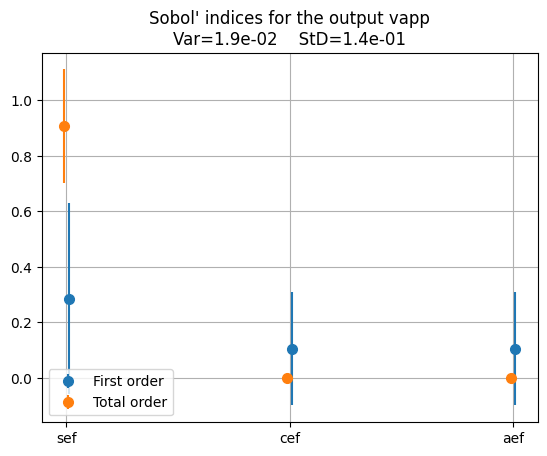

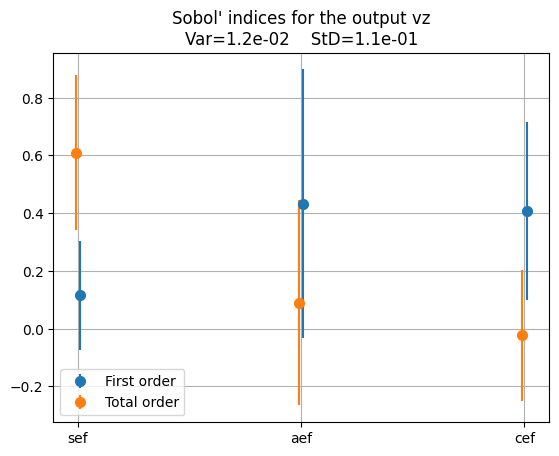

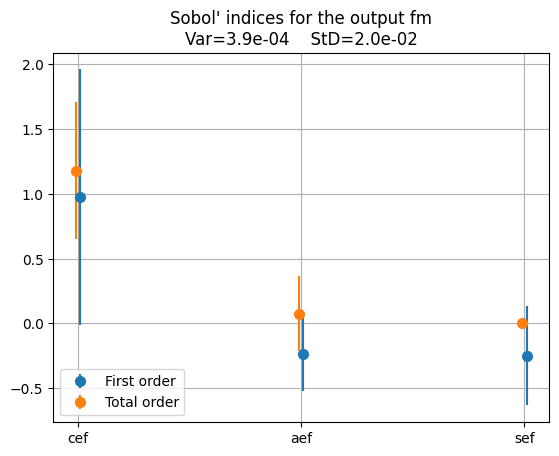

In [22]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))



